In [34]:
import pandas as pd
import numpy as np
import json
import torch
import tensorflow as tf

from datasets import Dataset, load_metric
from transformers import DistilBertTokenizerFast, AutoModelForSequenceClassification, DistilBertForSequenceClassification, DataCollatorWithPadding, Trainer, TrainerCallback, TrainingArguments
from torch.utils.data import DataLoader

from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import classification_report

In [35]:
import datasets 
dataset = datasets.load_dataset('ucberkeley-dlab/measuring-hate-speech', 'binary')


Using custom data configuration ucberkeley-dlab--measuring-hate-speech-c32713cabe528196
Found cached dataset parquet (/Users/animeshsengupta/.cache/huggingface/datasets/ucberkeley-dlab___parquet/ucberkeley-dlab--measuring-hate-speech-c32713cabe528196/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

In [36]:
df = dataset['train'].to_pandas()
print("Train dataset length:{}".format(df.shape[0]))
df=df[['hatespeech',
 'text',
 'respect',
 'insult']]
#  'humiliate',
#  'status',
#  'dehumanize',
#  'violence',
#  'genocide',
#  'attack_defend']]

Train dataset length:135556


In [37]:
df.drop_duplicates(subset=["text"])
df.shape[0]

135556

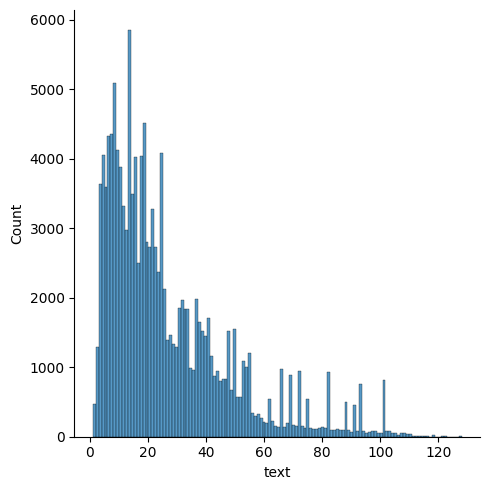

In [38]:
import seaborn as sns

seqlen=df.text.apply(lambda x:len(x.split()))
sns.displot(seqlen)

In [39]:
from sklearn.model_selection import train_test_split
dftr, dfte = train_test_split(df, test_size=0.2,random_state=77)
dftr,dfvl=train_test_split(dftr,test_size=0.2,random_state=77)


<AxesSubplot: ylabel='Frequency'>

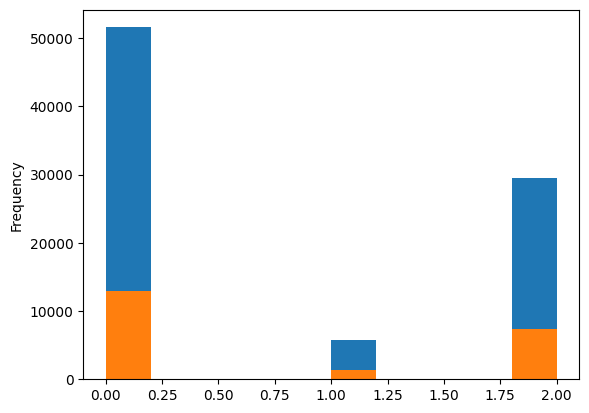

In [40]:
dftr["hatespeech"].plot(kind="hist")
dfvl["hatespeech"].plot(kind="hist")

<AxesSubplot: ylabel='Frequency'>

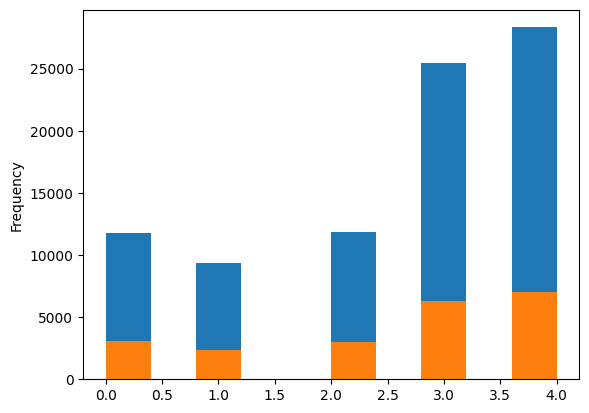

In [41]:
dftr["insult"].plot(kind="hist")
dfvl["insult"].plot(kind="hist")

In [42]:
#label length
label_cols=[x for x in dftr.columns.to_list() if x not in ["text"]]
label_length=np.sum([dftr[x].nunique() for x in label_cols])
print(label_length)

13


In [43]:
BASE_MODEL = "distilbert-base-uncased"
LEARNING_RATE = 1e-4
MAX_LENGTH = 120
BATCH_SIZE = 16
EPOCHS = 50
NUM_OF_LABELS=label_length

In [44]:
tokenizer = DistilBertTokenizerFast.from_pretrained(BASE_MODEL, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL,num_labels=NUM_OF_LABELS)


loading file https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt from cache at /Users/animeshsengupta/.cache/huggingface/transformers/0e1bbfda7f63a99bb52e3915dcf10c3c92122b827d92eb2d34ce94ee79ba486c.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/tokenizer.json from cache at /Users/animeshsengupta/.cache/huggingface/transformers/75abb59d7a06f4f640158a9bfcde005264e59e8d566781ab1415b139d2e4c603.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/tokenizer_config.json from cache at /Users/animeshsengupta/.cache/huggingface/transformers/8c8624b8ac8aa99c60c912161f8332de003484428

In [45]:
val=dftr.text.iloc[0]
out=tokenizer(val, truncation=True, padding="max_length", max_length=MAX_LENGTH)
print(pd.Series(out))

input_ids         [101, 9152, 13327, 2015, 1998, 2037, 4314, 281...
attention_mask    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
dtype: object


In [46]:
dftr.reset_index(drop=True,inplace=True)
dfvl.reset_index(drop=True,inplace=True)

In [47]:
def preprocess(df,cols_to_dummy,tokenizer):
    df=pd.get_dummies(data=df,columns=cols_to_dummy)
    dum_col_list=[[col for col in df if col.startswith(x)] for x in cols_to_dummy]
    dum_col = [item for sublist in dum_col_list for item in sublist]
    df["label"]=df[dum_col].values.tolist()
    df[["input_ids","attention_mask"]]=df.apply(lambda row: pd.Series(tokenizer(row['text'], truncation=True, padding="max_length", max_length=MAX_LENGTH)),axis=1)
    df=df.drop(columns=dum_col,axis=1)
    return df

In [48]:
cols_to_dummy=["hatespeech","insult","respect"]
dftr=preprocess(dftr,cols_to_dummy,tokenizer)
dfvl=preprocess(dfvl,cols_to_dummy,tokenizer)

In [49]:
dftr.head(5)

,text,label,input_ids,attention_mask
0,Niggers and their liberal friends steal everyt...,"[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]","[101, 9152, 13327, 2015, 1998, 2037, 4314, 281...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,Grandma and Granddad reunite to save there dau...,"[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0]","[101, 13055, 1998, 2882, 14697, 25372, 2000, 3...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,Notwithstanding Marriyum Aurangzeb sahiba's po...,"[1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]","[101, 26206, 9388, 3089, 10513, 2213, 15240, 3...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,does skin colour matter to world leaders? does...,"[1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]","[101, 2515, 3096, 6120, 3043, 2000, 2088, 4177...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,"""@iamkrause: No need to thank me, killing nigg...","[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]","[101, 1000, 1030, 24264, 2213, 22272, 8557, 10...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [50]:
HATESPEECH_SCORE_INDICES=range(0,3)
INSULT_SCORE_INDICES=range(3,8)
RESPECT_SCORE_INDICES=range(8,13)

In [51]:
def get_preds_from_logits(logits):
    ret = np.zeros(logits.shape)
    # The first 5 columns (GLOBAL_SCORE_INDICES) are for global scores. They should be handled with a multiclass approach
    # i.e. we fill 1 to the class with highest probability, and 0 into the other columns
    best_class1 = np.argmax(logits[:, HATESPEECH_SCORE_INDICES], axis=-1)
    ret[list(range(len(ret))), best_class1] = 1

    best_class2 = np.argmax(logits[:, INSULT_SCORE_INDICES], axis=-1) + INSULT_SCORE_INDICES[0]
    ret[list(range(len(ret))), best_class2] = 1

    best_class3 = np.argmax(logits[:, RESPECT_SCORE_INDICES], axis=-1) + RESPECT_SCORE_INDICES[0]
    ret[list(range(len(ret))), best_class3] = 1
    return ret

In [52]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    final_metrics = {}
    
    # Deduce predictions from logits
    predictions = get_preds_from_logits(logits)
    
    # Get f1 metrics for global scoring. Notice that f1_micro = accuracy
    final_metrics["f1_micro_for_global_score"] = f1_score(labels[:, HATESPEECH_SCORE_INDICES], predictions[:, HATESPEECH_SCORE_INDICES], average="micro")
    final_metrics["f1_macro_for_global_score"] = f1_score(labels[:, HATESPEECH_SCORE_INDICES], predictions[:, HATESPEECH_SCORE_INDICES], average="macro")
    
    # Get f1 metrics for causes
    final_metrics["f1_micro_for_causes"] = f1_score(labels[:, INSULT_SCORE_INDICES], predictions[:, INSULT_SCORE_INDICES], average="micro")
    final_metrics["f1_macro_for_causes"] = f1_score(labels[:, INSULT_SCORE_INDICES], predictions[:, INSULT_SCORE_INDICES], average="macro")
    
    # Get f1 metrics for emotions
    final_metrics["f1_micro_for_emotions"] = f1_score(labels[:, RESPECT_SCORE_INDICES], predictions[:, RESPECT_SCORE_INDICES], average="micro")
    final_metrics["f1_macro_for_emotions"] = f1_score(labels[:, RESPECT_SCORE_INDICES], predictions[:, RESPECT_SCORE_INDICES], average="macro")

    # The global f1_metrics
    final_metrics["f1_micro"] = f1_score(labels, predictions, average="micro")
    final_metrics["f1_macro"] = f1_score(labels, predictions, average="macro")
    
    # Classification report
    print("Classification report for global scores: ")
    print(classification_report(labels[:, HATESPEECH_SCORE_INDICES], predictions[:, HATESPEECH_SCORE_INDICES], zero_division=0))
    print("Classification report for causes: ")
    print(classification_report(labels[:, INSULT_SCORE_INDICES], predictions[:, INSULT_SCORE_INDICES], zero_division=0))
    print("Classification report for emotions: ")
    print(classification_report(labels[:, RESPECT_SCORE_INDICES], predictions[:, RESPECT_SCORE_INDICES], zero_division=0))
    return final_metrics

In [53]:
class MultiTaskClassificationTrainer(Trainer):
    def __init__(self, group_weights=None, **kwargs):
        super().__init__(**kwargs)
        self.group_weights = group_weights
        
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs[0]
        
        global_score_loss = torch.nn.functional.cross_entropy(logits[:, HATESPEECH_SCORE_INDICES], labels[:, HATESPEECH_SCORE_INDICES])
        emotion_loss = torch.nn.functional.cross_entropy(logits[:, INSULT_SCORE_INDICES], labels[:, INSULT_SCORE_INDICES])
        cause_loss = torch.nn.functional.cross_entropy(logits[:, RESPECT_SCORE_INDICES], labels[:, RESPECT_SCORE_INDICES])
        
        loss = self.group_weights[0] * global_score_loss + self.group_weights[2] * emotion_loss + self.group_weights[1] * cause_loss
        return (loss, outputs) if return_outputs else loss

In [54]:
class PrinterCallback(TrainerCallback):
    def on_epoch_end(self, args, state, control, logs=None, **kwargs):
        print(f"Epoch {state.epoch}: ")

In [55]:
dftr.reset_index(drop=True,inplace=True)
dfvl.reset_index(drop=True,inplace=True)
dftr=dftr.drop("text",axis=1)
dfvl=dfvl.drop("text",axis=1)


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type list).

In [59]:
from datasets import load_dataset
dstr = load_dataset('csv', data_files='Processed_train.csv')
dsvl = load_dataset('csv', data_files='Processed_validation.csv')

Using custom data configuration default-e4c93fdab161ea21
Found cached dataset csv (/Users/animeshsengupta/.cache/huggingface/datasets/csv/default-e4c93fdab161ea21/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-6690f9ad07da74f9
Found cached dataset csv (/Users/animeshsengupta/.cache/huggingface/datasets/csv/default-6690f9ad07da74f9/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


  0%|          | 0/1 [00:00<?, ?it/s]

AttributeError: 'DatasetDict' object has no attribute 'head'

In [58]:

training_args = TrainingArguments(
    output_dir="./models/distilbert-fine-tuned-asg",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    metric_for_best_model="f1_macro",
    load_best_model_at_end=True,
    weight_decay=0.01,
)

trainer = MultiTaskClassificationTrainer(
    model=model,
    args=training_args,
    train_dataset=dstr,
    eval_dataset=dsvl,
    compute_metrics=compute_metrics,
    callbacks=[PrinterCallback],
    group_weights=(1, 1, 1)
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [29]:
trainer.train()

***** Running training *****
  Num examples = 86755
  Num Epochs = 50
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 271150


  0%|          | 0/271150 [00:00<?, ?it/s]

KeyError: 14654

In [56]:
dftr.to_csv("Processed_train.csv")
dfvl.to_csv("Processed_validation.csv")


In [424]:
print(dftr.columns)

Index(['label', 'input_ids', 'attention_mask'], dtype='object')


In [ ]:
attention_mask